![JohnSnowLabs](https://sparknlp.org/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp/blob/master/examples/python/transformers/openvino/HuggingFace_OpenVINO_in_Spark_NLP_Florence2Transformer.ipynb)

# Import OpenVINO Florence2 models from HuggingFace 🤗 into Spark NLP 🚀

This notebook provides a detailed walkthrough on optimizing and importing Florence2 models from HuggingFace for use in Spark NLP, with [Intel OpenVINO toolkit](https://www.intel.com/content/www/us/en/developer/tools/openvino-toolkit/overview.html). The focus is on converting the model to the OpenVINO format and applying precision optimizations (INT8 and INT4), to enhance the performance and efficiency on CPU platforms using [Optimum Intel](https://huggingface.co/docs/optimum/main/en/intel/inference).

Let's keep in mind a few things before we start 😊

- OpenVINO support was introduced in `Spark NLP 5.4.0`, enabling high performance CPU inference for models. So please make sure you have upgraded to the latest Spark NLP release.
- Model quantization is a computationally expensive process, so it is recommended to use a runtime with more than 32GB memory for exporting the quantized model from HuggingFace.
- You can import Florence2 models via `Florence2`. These models are usually under the `Text Generation` category and have `Florence2` in their labels.
- Reference: [Florence2](https://huggingface.co/docs/transformers/model_doc/llama#transformers.Florence2)
- Some [example models](https://huggingface.co/models?search=Florence2)

## Table of Contents

1. [Setup and Installation](#setup-and-installation)
2. [Model Configuration](#model-configuration)
3. [Model Loading and Preparation](#model-loading-and-preparation)
4. [Model Conversion to OpenVINO](#model-conversion-to-openvino)
5. [Model Quantization](#model-quantization)
6. [Model Merger Implementation](#model-merger-implementation)
7. [Testing OpenVINO Model](#7-testing-openvino-model)


## 1. Setup and Installation

First, let's install all the required dependencies for this notebook.

In [7]:
# # Install OpenVINO and NNCF for model optimization
import platform

%pip install -q "einops" "torch>2.1" "torchvision" "matplotlib>=3.4" "timm>=0.9.8" "transformers==4.49" "pillow" "gradio>=4.19" --extra-index-url https://download.pytorch.org/whl/cpu
%pip install -q -U --pre "openvino>=2025.0"

if platform.system() == "Darwin":
    %pip install -q "numpy<2.0.0"

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import requests
from pathlib import Path

if not Path("ov_florence2_helper.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/a668dd2/notebooks/florence2/ov_florence2_helper.py")
    open("ov_florence2_helper.py", "w").write(r.text)


if not Path("gradio_helper.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/a668dd2/notebooks/florence2/gradio_helper.py")
    open("gradio_helper.py", "w").write(r.text)

if not Path("notebook_utils.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/a668dd2/utils/notebook_utils.py")
    open("notebook_utils.py", "w").write(r.text)

### Environment Configuration

Configure the environment to disable tokenizer parallelism for better compatibility.

In [2]:
import os
# Disable tokenizer parallelism to avoid potential issues
os.environ["TOKENIZERS_PARALLELISM"] = "false"

## 2. Model Configuration

Set up the model ID and quantization parameters for the conversion process.

In [3]:
from ov_florence2_helper import convert_florence2
import torch

/home/prabod/anaconda3/envs/fl23/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
model_ids = ["microsoft/Florence-2-base-ft", "microsoft/Florence-2-base", "microsoft/Florence-2-large-ft", "microsoft/Florence-2-large"]


## 3. Model Loading and Preparation

Load the model processor, configuration, and prepare the model for conversion to OpenVINO format.

In [ ]:
import shutil
from pathlib import Path
for model_id in model_ids:
    output_dir = f"./models/int4/{model_id}"
    # check if the model is already optimized
    if not os.path.exists(f"{output_dir}/merger_model.xml") and not os.path.exists(f"{output_dir}/merger_model.bin"):
        convert_florence2(model_id, output_dir)
    else:
        print(f"Model {model_id} already optimized.")

## 4. Model Conversion to OpenVINO

Define paths for the converted model components and implement conversion utilities.

In [25]:
for model_id in model_ids:
    output_dir = f"./models/int4/{model_id}"
    if not os.path.exists(f"{output_dir}/assets"):
        output_dir = Path(output_dir)
        assets_dir = output_dir/"assets"
        assets_dir.mkdir(exist_ok=True)

        # copy all the assets to the assets directory (json files, vocab files, etc.)
        for file in output_dir.glob("*.json"):
            shutil.copy(file, assets_dir)

In [7]:
def cleanup_torchscript_cache():
    """
    Helper function for removing cached model representation to prevent memory leaks
    during model conversion.
    """
    torch._C._jit_clear_class_registry()
    torch.jit._recursive.concrete_type_store = torch.jit._recursive.ConcreteTypeStore()
    torch.jit._state._clear_class_state()

## 5. Model Merger Implementation

Implement the model merger to combine text and image components.

In [8]:
import numpy as np
import torch

class MergeMultiModalInputs(torch.nn.Module):
    def __init__(self,image_seq_length=577, image_token_index=1):
        super().__init__()
        self.image_seq_length = image_seq_length
        self.image_token_index = image_token_index

    def forward(
        self,
        vision_embeds,
        inputs_embeds,
    ):
        final_embedding = torch.cat([vision_embeds, inputs_embeds], dim=1)
        return {
            "final_embedding": final_embedding
        }

In [10]:
import openvino as ov
import gc
for model_id in model_ids:
    print(f"Converting model {model_id} merger to OpenVINO format...")
    core = ov.Core()
    output_dir = f"./models/int4/{model_id}"
    model_merger_path = f"{output_dir}/merger_model.xml"
    multimodal_merger = MergeMultiModalInputs()
    with torch.no_grad():
        ov_model = ov.convert_model(
            multimodal_merger,
            example_input= {
               "inputs_embeds": torch.ones([2, 13, 768], dtype=torch.float32),
                "vision_embeds": torch.ones([2 ,577, 768], dtype=torch.float32),
            }
        )
        ov.save_model(ov_model, model_merger_path)
        del ov_model
        cleanup_torchscript_cache()
        gc.collect()

Converting model microsoft/Florence-2-base-ft merger to OpenVINO format...
Converting model microsoft/Florence-2-base merger to OpenVINO format...
Converting model microsoft/Florence-2-large-ft merger to OpenVINO format...
Converting model microsoft/Florence-2-large merger to OpenVINO format...


# 7. Testing OpenVINO Model




In [1]:
model_ids = ["microsoft/Florence-2-base-ft", "microsoft/Florence-2-base", "microsoft/Florence-2-large-ft", "microsoft/Florence-2-large"]


In [2]:
import openvino as ov
from pathlib import Path
core = ov.Core()
device = "CPU"

# lets pick the first model
model_id = model_ids[0]
output_dir = f"./models/int4/{model_id}"
output_dir = Path(output_dir)

output_dir

PosixPath('models/int4/microsoft/Florence-2-base-ft')

In [42]:
# paths for the exported models
encoder_path = output_dir / "encoder.xml"
decoder_path = output_dir / "decoder.xml"
image_embedding_path = output_dir / "image_embedding.xml"
text_embedding_path = output_dir / "text_embedding.xml"
merger_path = output_dir/"merger_model.xml"

In [43]:
# compile the models
encoder_model = core.compile_model(encoder_path, device)
decoder_model = core.compile_model(decoder_path, device)
image_embedding_model = core.compile_model(image_embedding_path, device)
text_embedding_model = core.compile_model(text_embedding_path, device)
merger_model = core.compile_model(merger_path, device)

In [44]:
import requests
from PIL import Image
import numpy as np
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained(output_dir, trust_remote_code=True)

prompt = "<OD>"

url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg?download=true"
image = Image.open(requests.get(url, stream=True).raw)

inputs_new = processor(text=prompt, images=image, return_tensors="pt")
request = decoder_model.create_infer_request()


input_names = {key.get_any_name(): idx for idx, key in enumerate(decoder_model.inputs)}
inputs = {}
# Set the initial input_ids
current_input_ids = inputs_new["input_ids"]
attention_mask = inputs_new["attention_mask"]
position_ids = attention_mask.long().cumsum(-1) - 1
position_ids.masked_fill_(attention_mask == 0, 1)
pixel_values = inputs_new["pixel_values"]
current_decoder_input_ids = [2] * current_input_ids.shape[0]
current_decoder_input_ids = torch.tensor(current_decoder_input_ids).unsqueeze(0)
generation_args = {"max_new_tokens": 200, "do_sample": False}
generated_tokens = []

text_embeds = torch.from_numpy(
    text_embedding_model(current_input_ids
    )[0]
)
vision_embeds = torch.from_numpy(
    image_embedding_model(
        {
            "pixel_values": pixel_values,
        }
    )[0]
)
final_embedding = torch.from_numpy(
    merger_model(
        {
            "inputs_embeds": text_embeds,
            "vision_embeds": vision_embeds,
        }
    )[0]
)
attention_mask = torch.ones_like(final_embedding[:, :, :1]).view(-1, final_embedding.shape[1])
encoder_hidden_states = torch.from_numpy(
    encoder_model(
        {
            "inputs_embeds": final_embedding,
            "attention_mask": attention_mask,
        }
    )[0]
)


for i in range(generation_args["max_new_tokens"]):
    # Generate input embeds each time 
    if i>0:
        inputs = {}
    # Prepare inputs for the model
    inputs["encoder_hidden_states"] = encoder_hidden_states
    inputs["encoder_attention_mask"] = attention_mask
    inputs["decoder_input_ids"] = current_decoder_input_ids

    if "beam_idx" in input_names:
        inputs["beam_idx"] = np.arange(encoder_hidden_states.shape[0], dtype=int)
    
    # Start inference
    request.start_async(inputs, share_inputs=True)
    request.wait()
    
    # Get the logits and find the next token
    logits = torch.from_numpy(request.get_tensor("logits").data)
    # print("logits", logits.shape)
    next_token = logits.argmax(-1)[0][-1]
    
    # Append the generated token
    generated_tokens.append(next_token)
    
    # Update input_ids with the new token
    current_decoder_input_ids = torch.cat([next_token.unsqueeze(0).unsqueeze(0)], dim=-1)
    
    current_input_ids = torch.cat([next_token.unsqueeze(0).unsqueeze(0)], dim=-1)
    if current_input_ids[0][-1].item() == 2:
        break
generated_text = processor.decode(generated_tokens, skip_special_tokens=False)
print(generated_text)

<s>car<loc_54><loc_334><loc_933><loc_774>wheel<loc_708><loc_576><loc_865><loc_772><loc_146><loc_584><loc_308><loc_773></s>


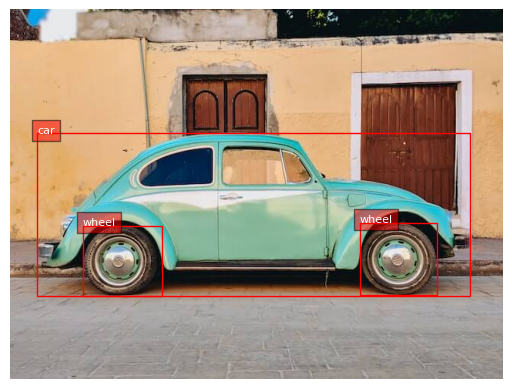

In [45]:
from gradio_helper import plot_bbox
parsed_answer = processor.post_process_generation(generated_text, task="<OD>", image_size=(image.width, image.height))

fig = plot_bbox(image, parsed_answer["<OD>"])

# 8. Import and Save in Spark NLP
- Let's install and setup Spark NLP in Google Colab
- This part is pretty easy via our simple script

In [ ]:
! wget -q http://setup.johnsnowlabs.com/colab.sh -O - | bash

Let's start Spark with Spark NLP included via our simple `start()` function

In [ ]:
import sparknlp

# let's start Spark with Spark NLP
spark = sparknlp.start()


In [5]:
imageClassifier = Florence2Transformer \
            .loadSavedModel(str(output_dir),spark) \
            .setInputCols("image_assembler") \
            .setOutputCol("answer") \
            .setMaxOutputLength(500)

25/05/26 10:57:22 WARN NativeLibrary: Failed to load library null: java.lang.UnsatisfiedLinkError: Can't load library: /tmp/openvino-native5213578236600476927/libtbb.so.2


In [6]:
imageClassifier.write().overwrite().save(f"file:///tmp/{model_id}_spark_nlp")

In [7]:
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.sql.functions import lit
from pyspark.ml import Pipeline
from pathlib import Path
import os

# download two images to test into ./images folder

url1 = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg?download=true"
url2 = "https://github.com/user-attachments/assets/8c9ae017-7837-4abc-ae92-c1054c9ec350"

Path("images").mkdir(exist_ok=True)

!wget -q -O images/car.jpg {url1}
!wget -q -O images/ocr.jpg {url2}



images_path = "file://" + os.getcwd() + "/images/"
image_df = spark.read.format("image").load(
    path=images_path
)

test_df = image_df.withColumn("text", lit("<OD>"))

image_assembler = ImageAssembler().setInputCol("image").setOutputCol("image_assembler")

imageClassifier = Florence2Transformer.load(f"file:///tmp/{model_id}_spark_nlp")\
            .setMaxOutputLength(1000) \
            .setInputCols("image_assembler") \
            .setOutputCol("answer")

pipeline = Pipeline(
            stages=[
                image_assembler,
                imageClassifier,
            ]
        )

model = pipeline.fit(test_df)

In [8]:
import io
from PIL import Image
import base64
from IPython.display import display

def run_task(image_path, task="<OD>"):
    """
    Function to predict the image using the trained Spark NLP model.
    Args:
        image_path (str): Path to the image file.
        task (str): Task type, default is "<OD>" for object detection.
    Returns:
        None: Displays the image with bounding boxes.
    """
    image_car_df = spark.read.format("image").load(
        path=image_path
    )
    image_car_df = image_car_df.withColumn("text", lit(task))
    generate_model_result = model.transform(image_car_df)

    gen_result = generate_model_result.collect()
    for row in gen_result:
        if "florence2_postprocessed_raw" in row["answer"][0].metadata:
            print("florence2_postprocessed_raw:", row["answer"][0].metadata["florence2_postprocessed_raw"])
            metadata = row["answer"][0].metadata
            result = row["answer"][0].result
            print("Result:", result)
            for key in metadata:
                if "florence2_image" in key:
                    image = metadata[key]
                    image = base64.b64decode(image)
                    image = Image.open(io.BytesIO(image))
                    display(image)
                if "task" in key:
                    print(f"Results for task {metadata[key]}:")

# 9. Test Visual Tasks

In [9]:
car_image_path = "file://" + os.getcwd() + "/images/" + "car.jpg"
ocr_image_path = "file://" + os.getcwd() + "/images/" + "ocr.jpg"

## 9.1 Object Detection

florence2_postprocessed_raw: [{"bbox":[34.88,160.56,597.44,371.76],"catName":"car"},{"bbox":[454.72,96.72,580.8000000000001,262.32],"catName":"door"},{"bbox":[453.44,276.71999999999997,553.92,370.8],"catName":"wheel"}]
Result: <s>car<loc_54><loc_334><loc_933><loc_774>door<loc_710><loc_201><loc_907><loc_546>wheel<loc_708><loc_576><loc_865><loc_772><loc_146><loc_584><loc_307><loc_773></s>
Results for task <OD>:


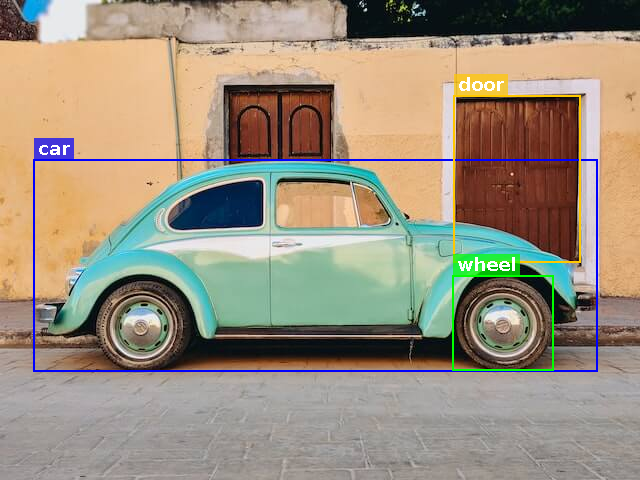

In [9]:
run_task(car_image_path, task="<OD>")

## 9.2 Dense Region Caption

florence2_postprocessed_raw: [{"bbox":[34.24,160.56,597.44,372.24],"catName":"car"}]
Result: <s>car<loc_53><loc_334><loc_933><loc_775></s>
Results for task <DENSE_REGION_CAPTION>:


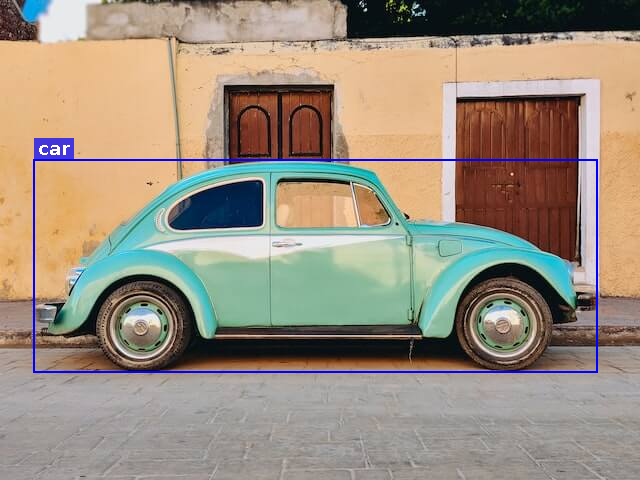

In [10]:
run_task(car_image_path, task="<DENSE_REGION_CAPTION>")

## 9.3 Captioning

In [11]:
for prompt in ["<CAPTION>", "<DETAILED_CAPTION>", "<MORE_DETAILED_CAPTION>"]:
    run_task(car_image_path, prompt)

florence2_postprocessed_raw: {"text":"A green car parked in front of a yellow building."}
Result: <s>A green car parked in front of a yellow building.</s>
Results for task <CAPTION>:


florence2_postprocessed_raw: {"text":"In this image we can see a car on the road. In the background we can see a wall, doors and trees."}
Result: <s>In this image we can see a car on the road. In the background we can see a wall, doors and trees.</s>
Results for task <DETAILED_CAPTION>:


florence2_postprocessed_raw: {"text":"A light green car is parked in front of a yellow building. There are two brown doors on the building. There is a brick sidewalk under the car. "}
Result: <s>A light green car is parked in front of a yellow building. There are two brown doors on the building. There is a brick sidewalk under the car. </s>
Results for task <MORE_DETAILED_CAPTION>:


## 9.4 Region Proposal

florence2_postprocessed_raw: [{"bbox":[34.24,160.56,597.44,371.76],"catName":"car"}]
Result: <s>car<loc_53><loc_334><loc_933><loc_774></s>
Results for task <REGION_PROPOSAL>:


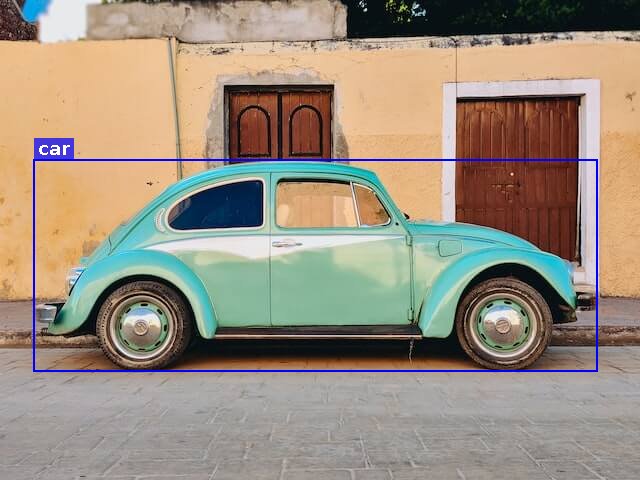

In [12]:
run_task(car_image_path, task="<REGION_PROPOSAL>")

## 9.5 Caption to Phrase Grounding

florence2_postprocessed_raw: [{"bbox":[[35.52,158.64,582.08,373.68]],"catName":"A green car"},{"bbox":[[0.32,0.24,639.04,303.59999999999997]],"catName":"a yellow building"}]
Result: <s>A green car<loc_55><loc_330><loc_909><loc_778>a yellow building<loc_0><loc_0><loc_998><loc_632></s>
Results for task <CAPTION_TO_PHRASE_GROUNDING> A green car parked in front of a yellow building.:


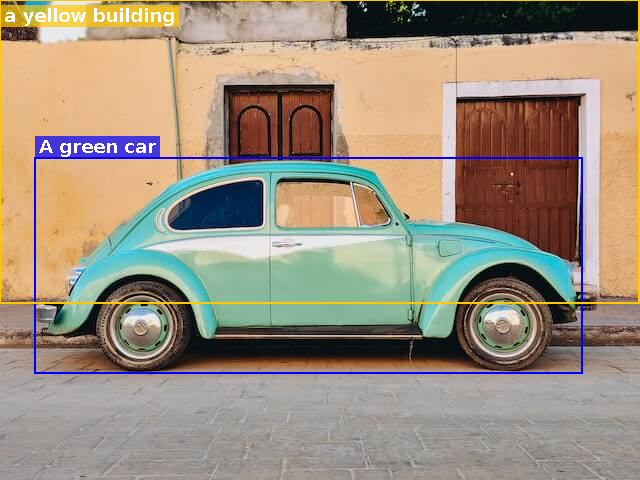

In [18]:
run_task(car_image_path, task="<CAPTION_TO_PHRASE_GROUNDING> A green car parked in front of a yellow building.")

## 9.6 Referring Expression Segmentation

florence2_postprocessed_raw: [{"polygons":[[184.0,177.84,270.4,161.04,372.16,167.76,409.28000000000003,220.56,506.56,230.64,575.04,262.32,578.88,292.56,598.08,292.56,598.08,311.76,578.88,311.76,578.88,321.84,553.92,325.2,546.88,356.4,523.84,372.24,475.2,367.91999999999996,457.28000000000003,342.0,200.64000000000001,338.64,184.0,364.56,136.0,372.24,102.08,356.4,93.12,332.88,47.04,336.24,34.88,306.0,66.24,299.28,68.16,270.0,84.16,266.64,84.16,256.56]],"catName":""}]
Result: <s><loc_287><loc_370><loc_422><loc_335><loc_581><loc_349><loc_639><loc_459><loc_791><loc_480><loc_898><loc_546><loc_904><loc_609><loc_934><loc_609><loc_934><loc_649><loc_904><loc_649><loc_904><loc_670><loc_865><loc_677><loc_854><loc_742><loc_818><loc_775><loc_742><loc_766><loc_714><loc_712><loc_313><loc_705><loc_287><loc_759><loc_212><loc_775><loc_159><loc_742><loc_145><loc_693><loc_73><loc_700><loc_54><loc_637><loc_103><loc_623><loc_106><loc_562><loc_131><loc_555><loc_131><loc_534></s>
Results for task <REFERRING_EXP

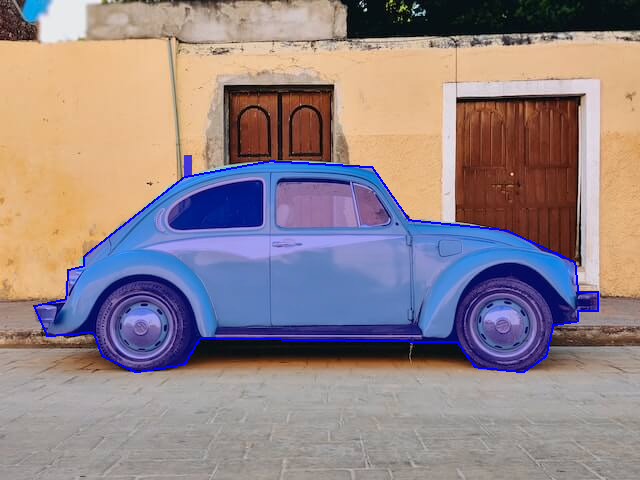

In [10]:
run_task(car_image_path, task="<REFERRING_EXPRESSION_SEGMENTATION> a green car")

## 9.7 Open Vocabulary Detection

florence2_postprocessed_raw: [{"bbox":[34.88,159.12,582.72,374.64],"catName":"a green car"}]
Result: <s>a green car<loc_54><loc_331><loc_910><loc_780></s>
Results for task <OPEN_VOCABULARY_DETECTION> a green car:


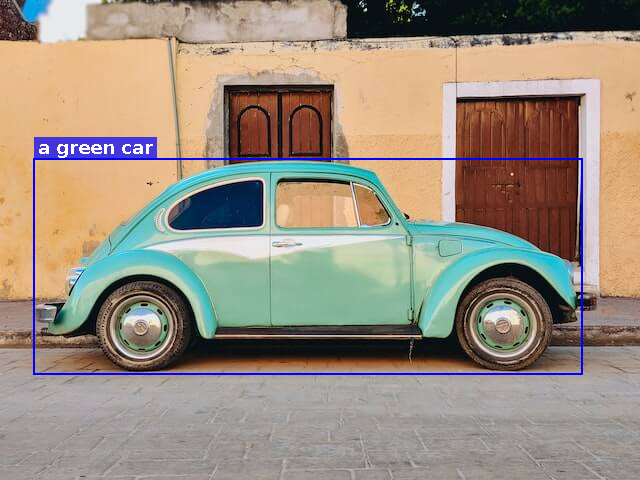

In [11]:
run_task(car_image_path, task="<OPEN_VOCABULARY_DETECTION> a green car")

## 9.8 OCR Related Tasks

In [13]:
run_task(ocr_image_path, task="<OCR>")

florence2_postprocessed_raw: {"text":"This is a handwrittenexampleWrite as good as you can."}
Result: <s>This is a handwrittenexampleWrite as good as you can.</s>
Results for task <OCR>:


florence2_postprocessed_raw: [{"quadBox":[28.874499999999998,43.847,591.7445,43.847,591.7445,91.769,28.874499999999998,91.769],"text":"This is a handwritten"},{"quadBox":[40.570499999999996,145.559,233.5545,143.603,233.5545,182.39700000000002,40.570499999999996,184.353],"text":"example"},{"quadBox":[40.570499999999996,236.187,686.0435,244.33700000000002,686.0435,284.435,40.570499999999996,281.175],"text":"Write as good as you can."}]
Result: <s>This is a handwritten<loc_39><loc_134><loc_809><loc_134><loc_809><loc_281><loc_39><loc_281>example<loc_55><loc_446><loc_319><loc_440><loc_319><loc_559><loc_55><loc_565>Write as good as you can.<loc_55><loc_724><loc_938><loc_749><loc_938><loc_872><loc_55><loc_862></s>
Results for task <OCR_WITH_REGION>:


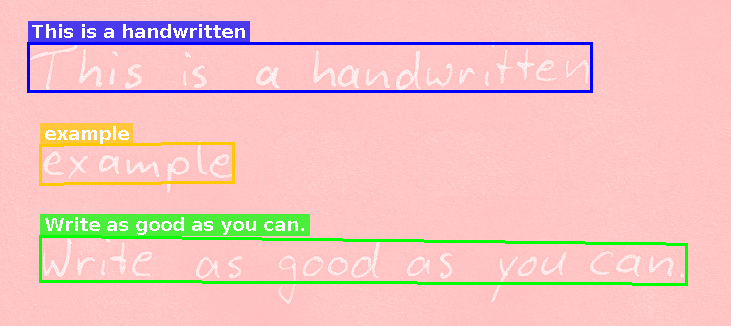

In [14]:
run_task(ocr_image_path, task="<OCR_WITH_REGION>")